In [2]:
import json
import matplotlib.pyplot as plt

In [3]:
with open('assets/liste-des-circuits-de-voie.json', 'r', encoding='utf-8') as f:
    voies_data = json.load(f)

In [4]:
with open('assets/gares-de-voyageurs.json', 'r', encoding='utf-8') as f:
    gares_data = json.load(f)

In [5]:
voies_segments = []
for voie in voies_data:
    if 'geo_shape' in voie and 'geometry' in voie['geo_shape']:
        if voie['geo_shape']['geometry']['type'] == "LineString":
            coordinates = voie['geo_shape']['geometry']['coordinates']
            voies_segments.append(coordinates)

In [6]:
gares_positions = []
for gare in gares_data:
    if 'position_geographique' in gare and gare['position_geographique'] != None:
        lon = gare['position_geographique']['lon']
        lat = gare['position_geographique']['lat']
        gares_positions.append((lon, lat))

/var/folders/37/sls145bs5gqc_f8s8mzn569r0000gn/T/ipykernel_21794/3613799356.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/gurkan/coding/python/tokenizer/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


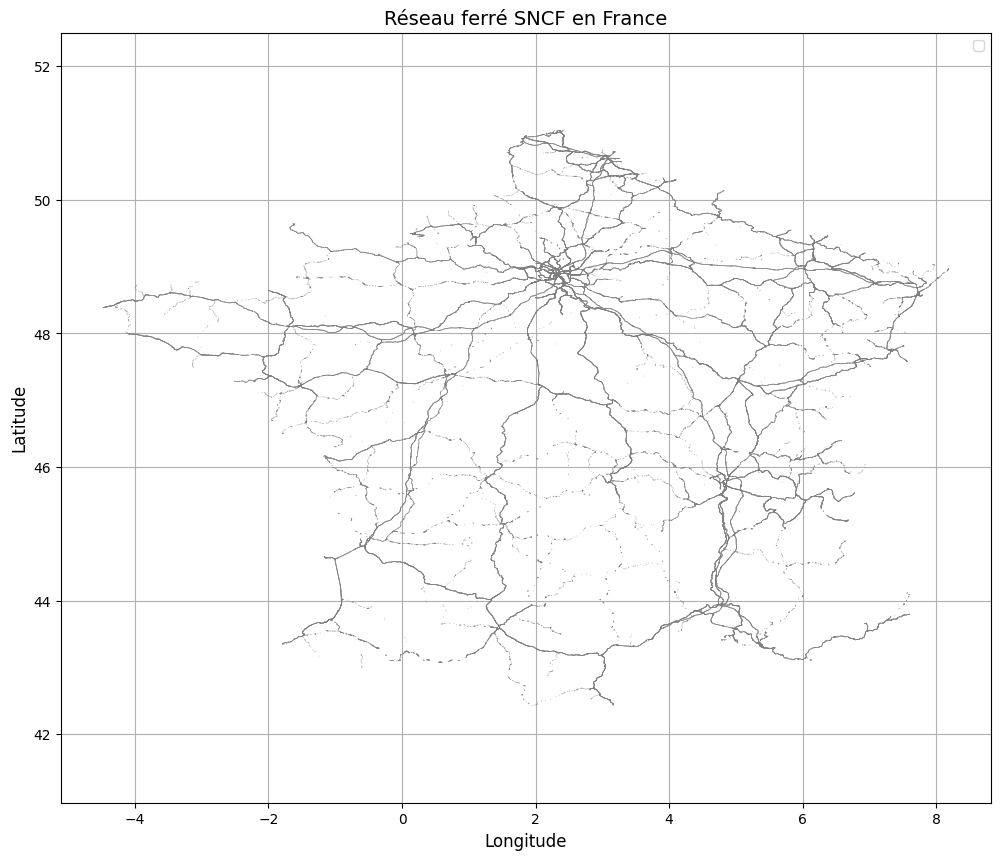

In [10]:
plt.figure(figsize=(12, 10))

for segment in voies_segments:
    lons, lats = zip(*segment)
    plt.plot(lons, lats, color='gray', linewidth=0.5, alpha=0.7)

plt.title("Réseau ferré SNCF en France", fontsize=14)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

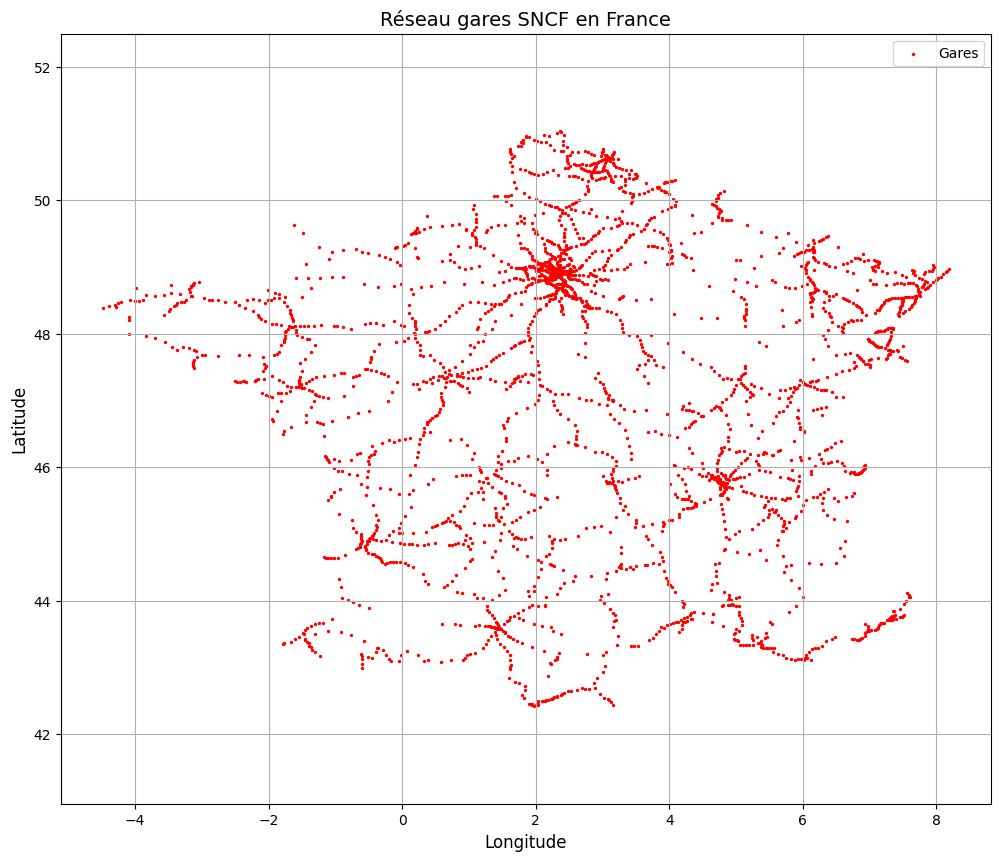

In [ ]:
plt.figure(figsize=(12, 10))
gare_lons, gare_lats = zip(*gares_positions)
plt.scatter(gare_lons, gare_lats, color='red', s=2, label='Gares')

plt.title("Réseau gares SNCF en France", fontsize=14)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

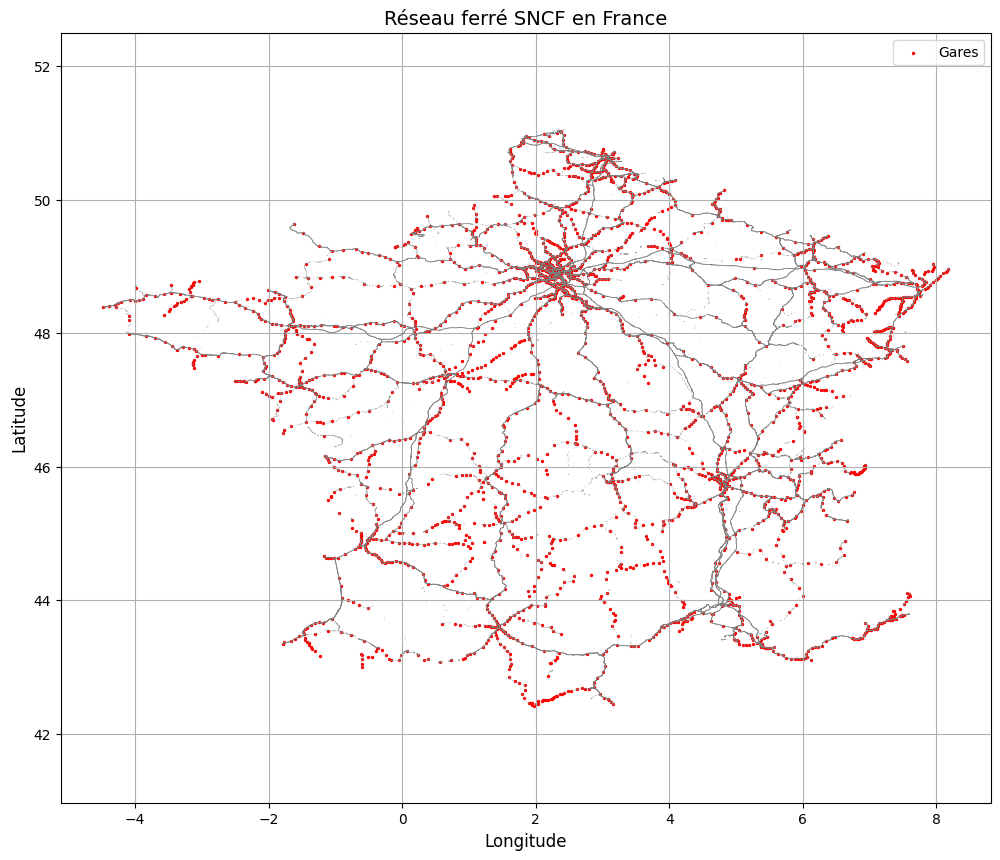

In [14]:
plt.figure(figsize=(12, 10))

for segment in voies_segments:
    lons, lats = zip(*segment)
    plt.plot(lons, lats, color='gray', linewidth=0.5, alpha=0.7)

gare_lons, gare_lats = zip(*gares_positions)
plt.scatter(gare_lons, gare_lats, color='red', s=2, label='Gares')

plt.title("Réseau ferré SNCF en France", fontsize=14)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [7]:
import math
import heapq

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    """Calcule la distance géographique en mètres entre deux points."""
    R = 6371000
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))


In [9]:
gares_dict = {gare['nom']: (gare['position_geographique']['lat'], gare['position_geographique']['lon']) for gare in gares_data if gare['position_geographique'] != None}

In [ ]:
graph = {gare['nom']: [] for gare in gares_data}

for voie in voies_data:
    if 'geo_shape' in voie and 'geometry' in voie['geo_shape']:
        if voie['geo_shape']['geometry']['type'] == "LineString":
            coordinates = voie['geo_shape']['geometry']['coordinates']

            for i in range(len(coordinates) - 1):
                lon1, lat1 = coordinates[i]
                lon2, lat2 = coordinates[i + 1]
                distance = haversine(lat1, lon1, lat2, lon2)
                # Trouver les gares les plus proches
                gare1 = min(gares_dict.keys(), key=lambda g: haversine(lat1, lon1, *gares_dict[g]))
                gare2 = min(gares_dict.keys(), key=lambda g: haversine(lat2, lon2, *gares_dict[g]))
                if gare1 != gare2:
                    graph[gare1].append((gare2, distance))
                    graph[gare2].append((gare1, distance))


In [176]:
ville_to_gares = {}
for gare in gares_data:
    nom_ville = gare.get('nom')
    nom_ville = nom_ville.lower()
    if not nom_ville:
        continue
    
    ville = nom_ville.split(" ")[0].strip()
    ville = ville.lower()
    if ville not in ville_to_gares:
        ville_to_gares[ville] = []
    ville_to_gares[ville].append(gare['nom'])

In [179]:
def trouver_gares(ville):
    return ville_to_gares.get(ville, [])

In [130]:
def dijkstra(graph, start, end):
    queue = []
    heapq.heappush(queue, (0, start))
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    previous_nodes = {node: None for node in graph}
    
    while queue:
        current_distance, current_node = heapq.heappop(queue)
        if current_distance > distances[current_node]:
            continue
        
        for neighbor, weight in graph[current_node]:
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(queue, (distance, neighbor))
                
    path = []
    current = end
    while current:
        path.append(current)
        current = previous_nodes[current]
    path.reverse()
    
    return path, distances[end]

In [145]:
def detecter_gares_principales(ville, gares_possibles, graph):
    # Trier les gares par connectivité décroissante
    gares_avec_connectivite = [(gare, len(graph.get(gare, []))) for gare in gares_possibles]
    gares_triees = sorted(gares_avec_connectivite, key=lambda x: x[1], reverse=True)
    
    # Filtrer les gares avec le nom de la ville pour renforcer la pertinence
    gares_filtrees = [gare for gare, _ in gares_triees if ville.lower() in gare.lower()]
    
    # Retourner les gares principales détectées
    return gares_filtrees if gares_filtrees else [gare for gare, _ in gares_triees]

In [157]:
def trouver_itineraire_avec_detours_v2(graph, depart, arrivee, detours, ville_to_gares):
    """
    Trouve l'itinéraire le plus rapide en passant par une liste de détours.
    
    :param graph: Graphe représentant le réseau SNCF
    :param depart: Ville de départ
    :param arrivee: Ville d'arrivée
    :param detours: Liste des villes par lesquelles passer
    :param ville_to_gares: Dictionnaire {ville: [gares]}
    :return: Chemin complet et distance totale
    """
    villes = [depart] + detours + [arrivee]

    chemin_complet = []
    distance_totale = 0

    for i in range(len(villes) - 1):
        ville_depart = villes[i]
        ville_arrivee = villes[i + 1]
        
        gares_depart = ville_to_gares.get(ville_depart, [])
        gares_arrivee = ville_to_gares.get(ville_arrivee, [])
        
        if not gares_depart:
            raise ValueError(f"Ville de départ non trouvée : {ville_depart}")
        if not gares_arrivee:
            raise ValueError(f"Ville d'arrivée non trouvée : {ville_arrivee}")
        
        gares_depart_principales = detecter_gares_principales(ville_depart, gares_depart, graph)
        gares_arrivee_principales = detecter_gares_principales(ville_arrivee, gares_arrivee, graph)
        
        min_distance = float('inf')
        meilleur_segment = None

        for gare_depart in gares_depart_principales:
            for gare_arrivee in gares_arrivee_principales:
                try:
                    chemin, distance = dijkstra(graph, gare_depart, gare_arrivee)
                    if distance < min_distance:
                        min_distance = distance
                        meilleur_segment = (chemin, distance)
                except KeyError:
                    continue

        if meilleur_segment:
            chemin_segment, distance_segment = meilleur_segment
            chemin_complet.extend(chemin_segment[:-1])  # On évite de dupliquer les nœuds
            distance_totale += distance_segment
        else:
            raise ValueError(f"Aucun itinéraire valide trouvé entre {ville_depart} et {ville_arrivee}.")

    # Ajouter la dernière gare du dernier segment
    chemin_complet.append(chemin_segment[-1])
    return chemin_complet, distance_totale


In [11]:
with open("graph_sncf.json", "r", encoding="utf-8") as f:
    graph = json.load(f)

In [112]:
connectivite = {gare: len(adjacents) for gare, adjacents in graph.items()}

In [ ]:
depart = "Strasbourg"
arrivee = "Marseille"

if depart not in graph or arrivee not in graph:
    print("Une des gares spécifiées n'existe pas dans les données.")
else:
    distance, chemin = dijkstra(graph, depart, arrivee)
    print(f"Distance totale : {distance:.2f} mètres")
    print(f'Chemin: {chemin}')
    print(f'Depart: {chemin[0]}')
    print(f'Arrivee: {chemin[-1]}')


Une des gares spécifiées n'existe pas dans les données.


In [202]:
depart = "strasbourg"
arrivee = "bordeaux"
detours = ["lyon"]

chemin, distance = trouver_itineraire_avec_detours_v2(graph, depart, arrivee, detours, ville_to_gares)

print("Itinéraire avec détours :")
print(f"  Chemin : {chemin}")
print(f"  Gare départ : {chemin[0]}")
print(f"  Gare arrivée : {chemin[-1]}")
print(f'  Détours: {detours}')
print(f"  Distance totale : {(distance/10):.2f} km")

Itinéraire avec détours :
  Chemin : ['Strasbourg', 'Bischheim', 'Mundolsheim', 'Vendenheim', 'Stephansfeld', 'Schwindratzheim', 'Hochfelden', 'Wilwisheim', 'Dettwiller', 'Steinbourg', 'Saverne', 'Lutzelbourg', 'Réding', 'Sarrebourg', 'Berthelming', 'Bénestroff', 'Morhange', 'Herny', 'Rémilly', 'Lorraine TGV', 'Vandières', 'Pont-à-Mousson', 'Commercy', 'Pagny-sur-Meuse', 'Foug', 'Neufchâteau', 'Rozières-sur-Mouzon', 'Langres', 'Culmont - Chalindrey', 'Is-sur-Tille', 'Gemeaux', 'Saint-Julien - Clénay', 'Bretigny - Norges', 'Ruffey-lès-Echirey', 'Dijon Porte Neuve', 'Dijon', 'Ouges', 'Genlis', 'Collonges-lès-Premières', 'Auxonne', 'Orchamps', 'Ranchot', 'Saint-Vit', 'Dannemarie - Velesmes', 'Franois', 'Montferrand - Thoraise', 'Torpes - Boussières', 'Byans-sur-Doubs', 'Liesle', 'Arc-et-Senans', 'Mouchard', 'Arbois', 'Poligny', 'Saint-Lothain', 'Domblans - Voiteur', 'Lons-le-Saunier', 'Cousance', 'Saint-Amour', 'Bourg-en-Bresse', 'Ceyzériat', 'Saint-Martin-du-Mont', "Pont-d'Ain", 'Ambrona

In [196]:
gares_depart = trouver_gares(depart)
gares_arrivee = trouver_gares(arrivee)

In [197]:
if not gares_depart or not gares_arrivee:
    print(f"Ville de départ non trouvée : {depart}")
    print(f"Ville d'arrivée non trouvée : {arrivee}")
else:
    print(f"Gares possibles pour {depart} : {gares_depart}")
    print(f"Gares possibles pour {arrivee} : {gares_arrivee}")
    min_distance = float('inf')
    meilleur_chemin = None
    meilleure_gare_depart = None
    meilleure_gare_arrivee = None

    for gare_depart in sorted(gares_depart, key=lambda x: connectivite.get(x, 0), reverse=True):
        for gare_arrivee in sorted(gares_arrivee, key=lambda x: connectivite.get(x, 0), reverse=True):
            try:
                chemin, distance = dijkstra(graph, gare_depart, gare_arrivee)
                score = distance - (connectivite.get(gare_depart, 0) + connectivite.get(gare_arrivee, 0))
                
                if score < min_distance:
                    min_distance = score
                    meilleur_chemin = chemin
                    meilleure_gare_depart = gare_depart
                    meilleure_gare_arrivee = gare_arrivee
            except KeyError:
                continue


    if meilleur_chemin is not None:
        print(f"Meilleur itinéraire trouvé :")
        print(f"  Gare de départ : {meilleure_gare_depart}")
        print(f"  Gare d'arrivée : {meilleure_gare_arrivee}")
        print(f"  Chemin : {meilleur_chemin}")
        print(f"  Distance totale : {(min_distance/10):.2f} km")
        
    else:
        print("Aucun itinéraire valide trouvé entre les villes spécifiées.")


Gares possibles pour strasbourg : ['Strasbourg', 'Strasbourg Roethig']
Gares possibles pour paris : ['Paris Austerlitz', "Paris Bercy Bourgogne - Pays d'Auvergne", 'Paris Est', 'Paris Gare de Lyon', 'Paris Gare du Nord', 'Paris Montparnasse', 'Paris Saint-Lazare']
Meilleur itinéraire trouvé :
  Gare de départ : Strasbourg
  Gare d'arrivée : Paris Gare du Nord
  Chemin : ['Strasbourg', 'Bischheim', 'Mundolsheim', 'Vendenheim', 'Stephansfeld', 'Schwindratzheim', 'Hochfelden', 'Wilwisheim', 'Dettwiller', 'Steinbourg', 'Saverne', 'Lutzelbourg', 'Réding', 'Sarrebourg', 'Berthelming', 'Bénestroff', 'Morhange', 'Herny', 'Rémilly', 'Lorraine TGV', 'Vandières', 'Pagny-sur-Moselle', 'Novéant-sur-Moselle', 'Onville', 'Lérouville', 'Nançois - Tronville', 'Bar-le-Duc', 'Revigny-sur-Ornain', 'Saint-Dizier', 'Vitry-le-François', 'Châlons-en-Champagne', 'Avenay', 'Ay', 'Épernay', 'Dormans', 'Château-Thierry', 'Chézy-sur-Marne', "Nogent-l'Artaud - Charly", 'Nanteuil - Saâcy', 'La Ferté-sous-Jouarre', '

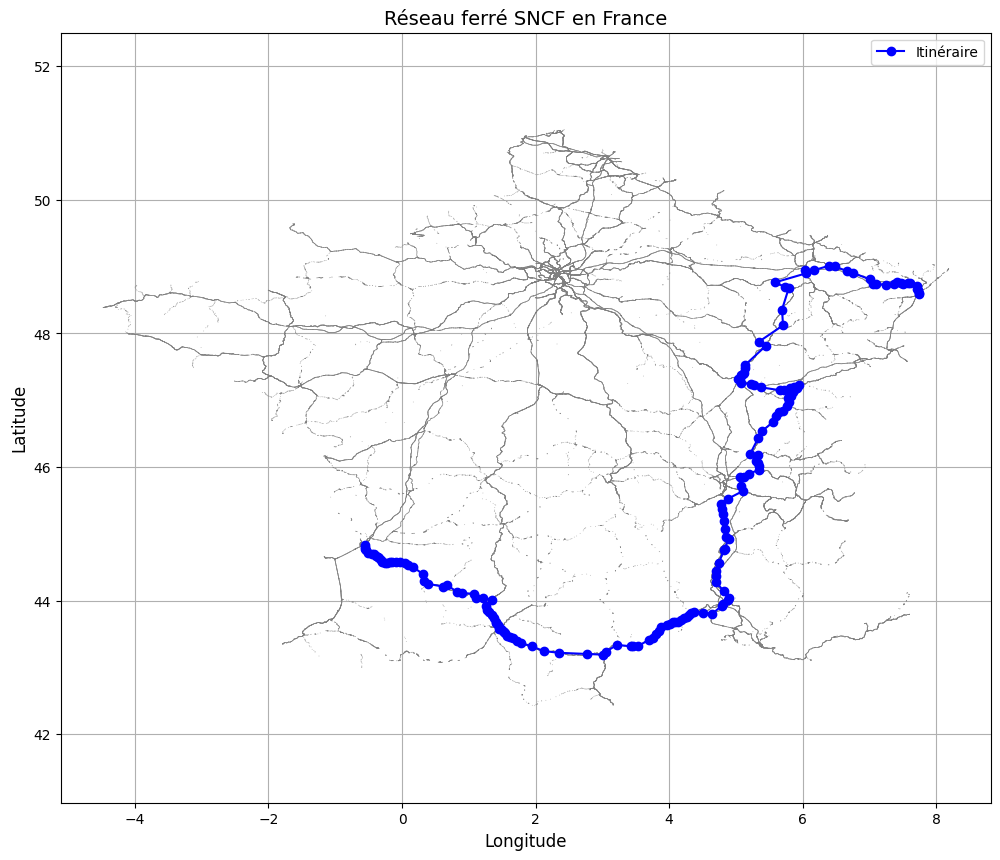

In [203]:
coordinates = []
for gare in chemin:
    if gare in gares_dict:
        coordinates.append(gares_dict[gare])
    else:
        print(f"Coordonnées manquantes pour la gare : {gare}")

lats_chemin, lons_chemin = zip(*coordinates)

plt.figure(figsize=(12, 10))

for segment in voies_segments:
    lons, lats = zip(*segment)
    plt.plot(lons, lats, color='gray', linewidth=0.5, alpha=0.7)

plt.plot(lons_chemin, lats_chemin, marker='o', color='blue', label='Itinéraire')  # Lignes et points

plt.title("Réseau ferré SNCF en France", fontsize=14)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [26]:
graph_filepath = "graph_sncf.json"
with open(graph_filepath, 'w', encoding='utf-8') as f:
    json.dump(graph, f, ensure_ascii=False, indent=2)